In [126]:
import pandas as pd
import numpy as np
import seaborn as np
from matplotlib import pyplot as plt
import re

In [127]:
global measurement

In [128]:
def extract_measurement(b_list):

    # this function extract the data points from B3,B4,B5 and 
    # And return clean data to get_measurment() in dictionay format 
    
    x_spos = b_list.index('LengthValue') # starting index of the x values
    y_spos = b_list.index('Value')# starting index of the y values
    y_epos = len(b_list)# the ending pos of y values
    
    x = b_list[x_spos + 1:y_spos]
    y = b_list[y_spos + 1: y_epos-1]

    null_index = set() # a set to keep the index of null values in either x or y
    
    # loop over x and get the index of the 'null' elements
    for index,value in enumerate(x):
        if value == "null":
            null_index.add(index)

    # loop over y and get the index of the 'null' elements
    for index,value in enumerate(y):
        if value == "null":
            null_index.add(index)    
    

    # removing the x,y pair with null value in either of them
    x = [value for idx, value in enumerate(x) if idx not in null_index]
    y = [value for idx, value in enumerate(y) if idx not in null_index]

    # changing the elements of x and y from string to float
    x_float =[float(item) for item in x]
    y_float =[float(item) for item in y]

    xy_dict = dict(zip(x_float,y_float)) # zip x and y  in dictionary
    print(len(xy_dict))
    #print(xy_dict)

    return xy_dict




def get_measurement(coil_id):

    # this function load the data for B3,B4,B5 measurments
    # It split the data based on ";"
    # It calls extract_measuremnt() function to extract the 
    # clean data pairs for B3,B4,B5
    # And return the values in dictionary format

    print('************************************')
    print("coil Id: ", coil_id)
    root_directory = "data/SampleProcessedData/"

    b3_df = pd.read_csv(root_directory + str(coil_id ) + "B3.csv")
    b4_df = pd.read_csv(root_directory + str(coil_id ) + "B4.csv")
    b5_df = pd.read_csv(root_directory + str(coil_id ) + "B5.csv")

    b3_list = re.split(';', str(b3_df.columns))
    b4_list = re.split(';', str(b4_df.columns))
    b5_list = re.split(';', str(b5_df.columns))

    b_lists = [b3_list,b4_list,b5_list]

    all_B_list = [] # this list contain all xy_dict for B3,B4,B5(it is list of dictionaries)
    for b_list in b_lists:
        all_B_list.append(extract_measurement(b_list))
        
    
    print('*********************************')


    
    return all_B_list # return list of dictionaries
    



    
 
    

    

In [129]:
def label_observation():

    # this function get the coil_Id and call the get_measurment()
    # function to get the cleaned value for B3,B4 and B5 in dictionary format
    # from the dictionary it checks if there is constriction or not
    # and add the result to the coil_df

     #load the dataset
     coil_df = pd.read_excel('data/CoilDataInput.xlsx')
     count = 0

     measurement = get_measurement(300090)
     print(measurement)
     
     for element in measurement:
        a = set()
        for key,value in element.items():
          a.add(int(key))
        print(a)
     
         



     return measurement

     



     


************************************
coil Id:  300090
1279
1279
1250
*********************************
[{0.0: 1490.6, 0.4038525: 1511.3, 0.8075924: 1523.4, 1.210457: 1525.6, 1.613209: 1524.8, 2.016072: 1523.3, 2.419044: 1521.8, 2.821908: 1521.2, 3.224332: 1520.5, 3.626756: 1519.8, 4.029399: 1519.3, 4.432591: 1518.9, 4.836003: 1518.3, 5.239743: 1518.1, 5.643155: 1518.1, 6.046679: 1517.6, 6.450639: 1517.0, 6.855699: 1516.8, 7.260867: 1516.3, 7.666036: 1515.9, 8.071204: 1515.6, 8.476592: 1514.8, 8.882421: 1515.2, 9.288905: 1515.0, 9.695828: 1515.0, 10.10275: 1515.0, 10.50858: 1514.5, 10.9143: 1515.0, 11.32078: 1514.8, 11.72683: 1514.1, 12.13353: 1514.2, 12.54024: 1514.5, 12.94639: 1515.1, 13.35354: 1514.8, 13.76112: 1514.4, 14.16848: 1514.1, 14.57695: 1513.7, 14.98552: 1514.0, 15.39354: 1514.5, 15.80156: 1514.9, 16.21024: 1514.5, 16.61937: 1514.6, 17.02826: 1515.0, 17.43716: 1515.2, 17.84562: 1514.9, 18.25496: 1514.9, 18.6643: 1514.8, 19.07452: 1514.7, 19.48475: 1514.9, 19.89485: 1515.6, 

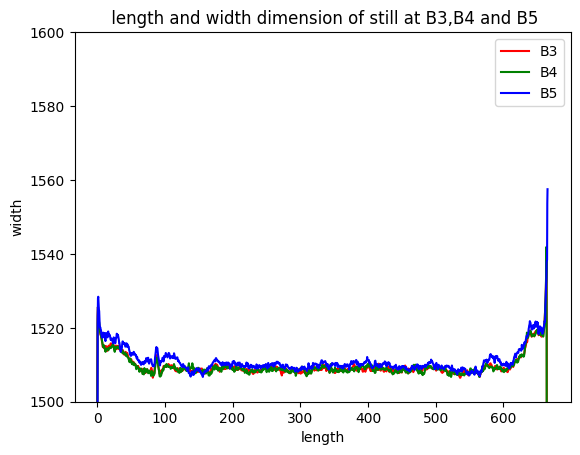

In [132]:
def visualize_measurments():
    measurement = label_observation()

    b3 = measurement[0].items()
    b4 = measurement[1].items()
    b5 = measurement[2].items()
    
    
    x_3, y_3 = zip(*b3)
    x_4, y_4 = zip(*b4)
    x_5, y_5 = zip(*b5)

    plt.plot(x_3, y_3, color = 'r', label = 'B3')
    plt.plot(x_4, y_4, color = 'g', label = 'B4')
    plt.plot(x_5, y_5, color = 'b', label = 'B5')

    plt.xlabel("length")
    plt.ylabel("width")
    plt.title(" length and width dimension of still at B3,B4 and B5")
    plt.ylim(1500, 1550)
    plt.xlim(0,500)
    plt.legend()
    plt.show()
    
visualize_measurments()
    